# Importing Necessary Libraries

In [43]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# Preparation and reading data

In [9]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [10]:
df = rawToDf('data.txt', '12hr')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13655 non-null  datetime64[ns]
 1   user       13655 non-null  object        
 2   message    13655 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 320.2+ KB


In [12]:
df.sample(10)

,date_time,user,message
12193,2020-09-13 20:10:00,+91 97694 89970,It should work actually u knw. Aise idts main ...
3085,2020-03-14 15:33:00,+91 95949 08570,Dheeraj asked something to him and he's like b...
1329,2020-02-20 23:43:00,"Tanay Kamath (TSEC, CS)",Engineering graphics🤣🙏
9034,2020-07-19 12:37:00,"Darshan Rander (TSEC, IT)",Nhi just saw one of repo don't have any stars
10085,2020-08-19 09:45:00,"Tanay Kamath (TSEC, CS)",💯🔥
11140,2020-09-03 12:54:00,"Tanay Kamath (TSEC, CS)",Didn't see the code
10522,2020-08-25 22:31:00,"Tanay Kamath (TSEC, CS)",true
1260,2020-02-20 23:30:00,+91 75078 05454,@918080142783
10345,2020-08-24 13:19:00,+91 88284 70904,Light gaya tha lol
9562,2020-08-10 12:33:00,"Kartik Soneji (TSEC, CS)",


# An important observation
* One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an empty string.
* This can be because, the message might just contain emojis. #### To see, how many such rows are there, we can use df[df['message'] == ""].shape[0]

In [13]:
df[df['message'] == ""].shape[0]

538

# Adding extra helper columns for analysis and visualization

In [14]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [15]:
df

,date_time,user,message,day,month,year,date
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,Sun,Jan,2020,2020-01-26
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...",Fri,Jan,2020,2020-01-24
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,Sun,Jan,2020,2020-01-26
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,Sun,Jan,2020,2020-01-26
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,Sun,Jan,2020,2020-01-26
...,...,...,...,...,...,...,...
13650,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya,Fri,Oct,2020,2020-10-02
13651,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅,Fri,Oct,2020,2020-10-02
13652,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?,Fri,Oct,2020,2020-10-02
13653,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup,Fri,Oct,2020,2020-10-02


# Overall frequency of total messages on the group.

In [16]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2020-01-24,1
1,2020-01-26,105
2,2020-01-27,90
3,2020-01-28,126
4,2020-01-29,118
...,...,...
237,2020-09-28,144
238,2020-09-29,49
239,2020-09-30,167
240,2020-10-01,91


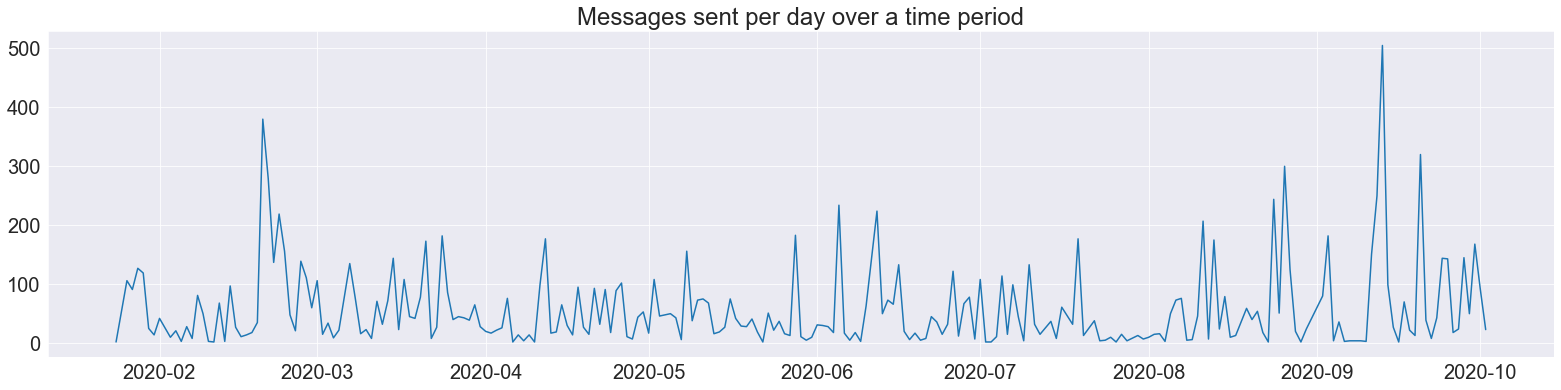

In [17]:
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# Top 10 most active days.

In [18]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2020-09-13,504
1,2020-02-20,379
2,2020-09-20,319
3,2020-08-26,299
4,2020-02-21,278
5,2020-09-12,249
6,2020-08-24,243
7,2020-06-05,233
8,2020-06-12,223
9,2020-02-23,218


c:\users\91894\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


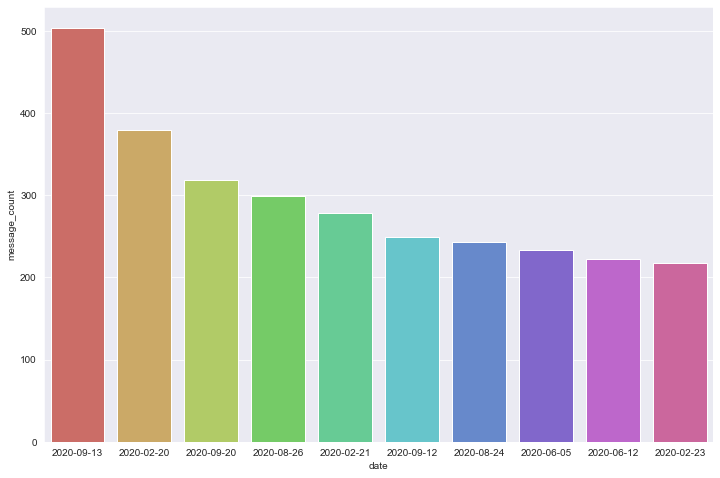

In [19]:
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(top10days.date, top10days.message_count, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

In [20]:
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


In [21]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


# Now, visualizing top 10 active users.

In [ ]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
    
top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

# Starting with a basic plot.

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

 # Now, I will be trying different visualization methods. 

Plotting a simple line graph.

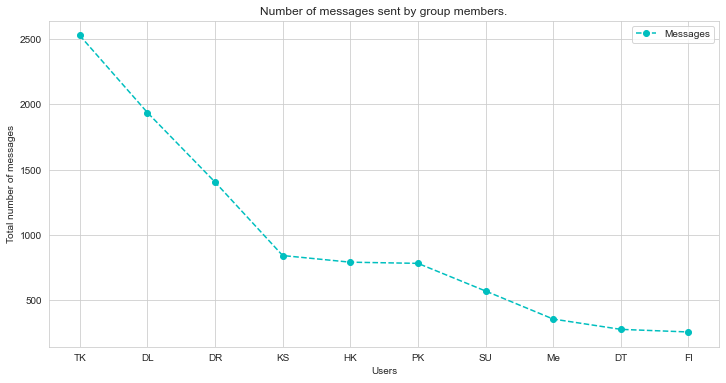

In [23]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

Plotting a bar chart and line graph together.

In [ ]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

# Beautifying Default Styles using Seaborn

c:\users\91894\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


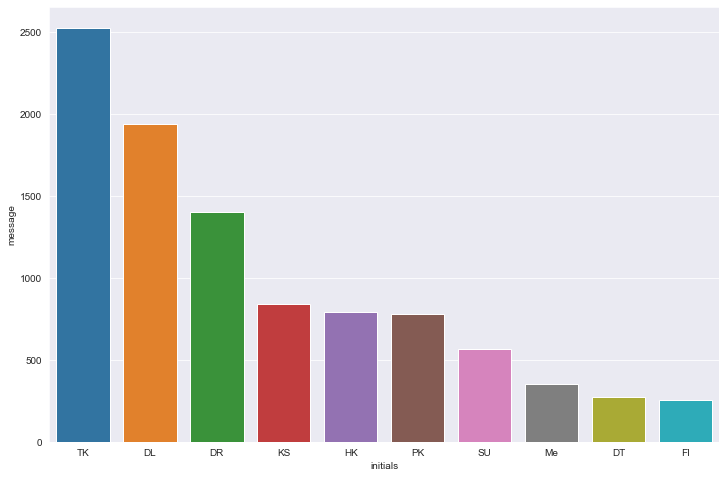

In [25]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(top10df.initials, top10df.message, data=top10df);

# Defining a function to tackle the problem

In [28]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

# Now, we have a really nice set of colours for each person, with which we can visualize using sns.palplot.

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'Me': '#577590',
 'DT': '#6D597A',
 'FI': '#003F88'}

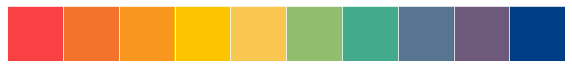

In [26]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

In [53]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

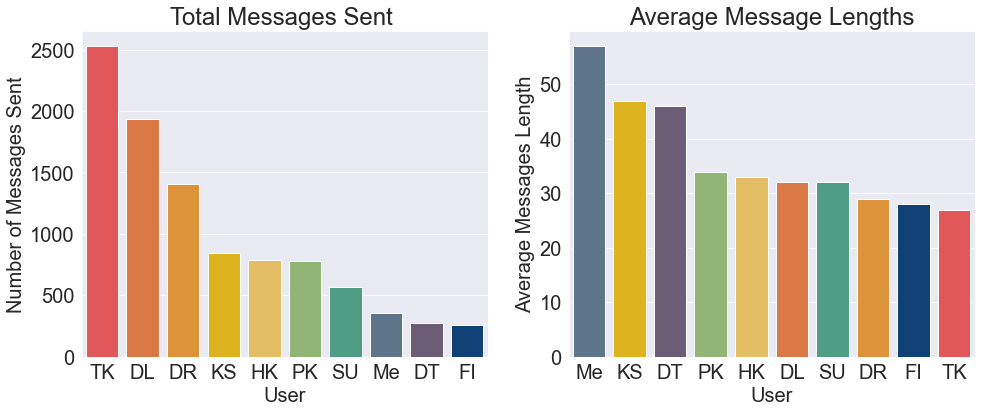

In [54]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(top10df.initials, top10df.message, data=top10df, ax = axes[0], palette=get_colors_of_certain_order(top10df.initials));     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(top10df_msg.initials, top10df_msg.avg_message_length, ax = axes[1], palette = get_colors_of_certain_order(top10df_msg.initials))    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

In [ ]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

In [34]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(top10media.initials, top10media.media_sent, palette="CMRmap");

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format = 'svg')

NameError: name 'top10media' is not defined

<Figure size 1080x432 with 0 Axes>

In [37]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

c:\users\91894\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


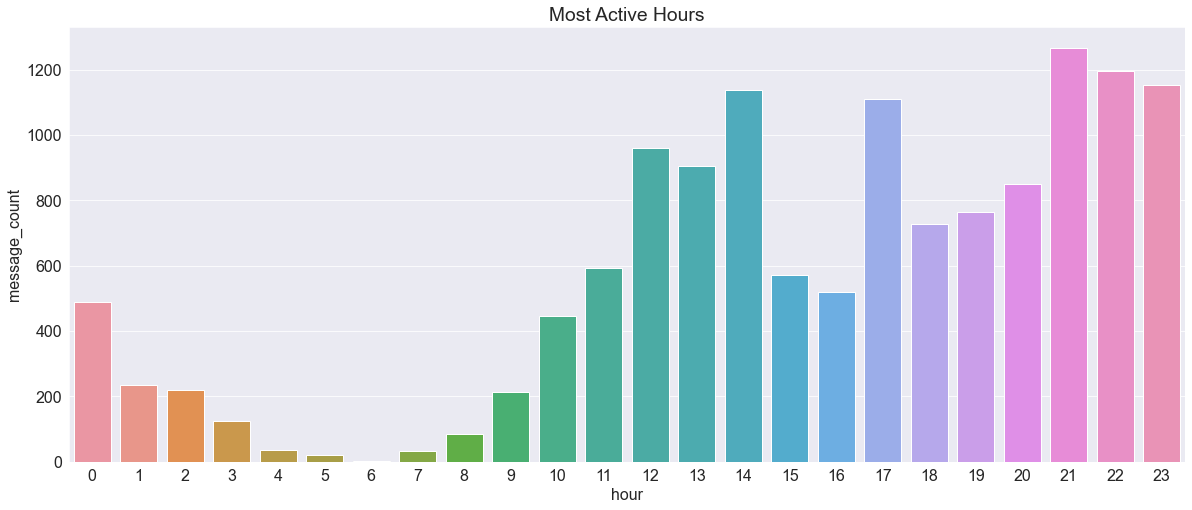

In [38]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')


In [41]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]

c:\users\91894\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


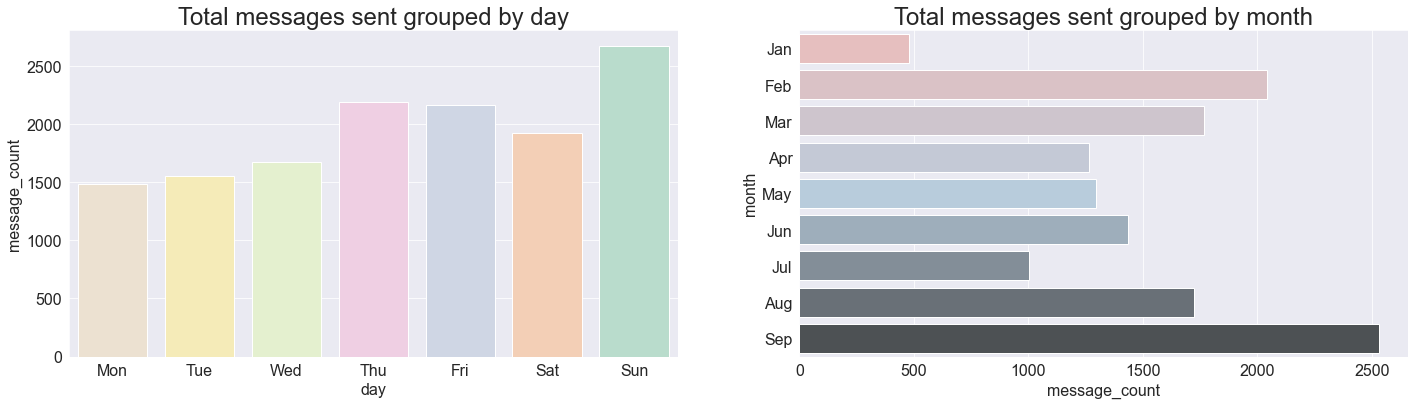

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(grouped_by_day.day, grouped_by_day.message_count, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

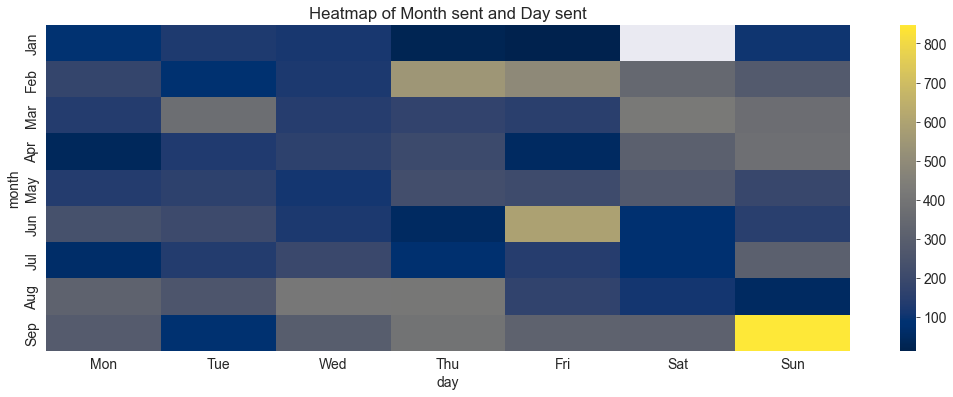

In [44]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')